## The 1cycle policy
## What is 1cycle?
这个回调允许我们使用Leslie Smith的1循环策略轻松训练网络。 要了解有关训练神经网络的1循环技术的更多信息，请查看Leslie Smith的论文，并获得更加图形化和直观的解释，查看Sylvain Gugger的帖子。

要使用我们的1周期政策，我们需要最佳学习率。 我们可以通过使用可以使用lr_finder调用的学习速率查找器来找到该学习速率。 它将通过超越大范围的学习率进行模拟训练，然后根据损失绘制它们。 我们将在最小值之前选择一个值，其中损失仍在改善。 我们的图表看起来像这样：
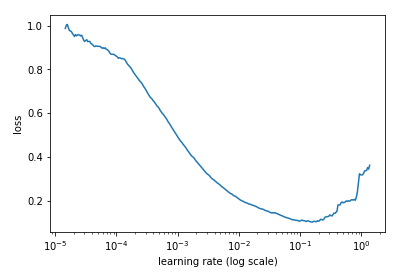

这里3e-2和e-2之间的任何东西都是个好主意。

接下来，我们将应用具有所选学习率的1周期策略作为最大学习率。 原始1循环策略有三个步骤：

1. 我们逐渐将学习率从lr_max / div_factor提高到lr_max，同时我们逐渐减少从mom_max到mom_min的动量。
2. 我们做的恰恰相反：我们逐渐将学习率从lr_max降低到lr_max / div_factor，同时我们逐渐增加从mom_min到mom_max的动量。
3. 我们进一步将学习率从lr_max / div_factor降低到lr_max /（div_factor x 100），我们保持动力稳定在mom_max。

这给出了以下形式：

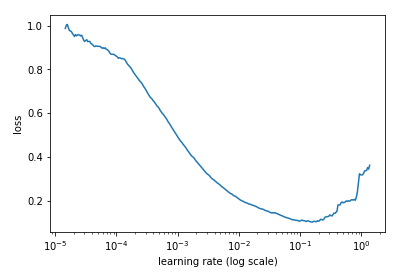

未发表的工作通过仅使用两个阶段表现出更好的结果：相同的阶段1，接着是第二阶段，其中我们进行从lr_max到0的余弦退火。通过遵循对称余弦，动量从mom_min变为mom_max（参见图a 位在下面）。

### 基础训练
单周期政策允许非常快速地训练，这种现象被称为超收敛。 为了在实践中看到这一点，我们将首先训练CNN，看看我们的结果与使用fit_one_cycle时的OneCycleScheduler进行比较。

In [1]:
from fastai.vision import *
from fastai.basics import *
from fastai.callbacks import *

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)
model = simple_cnn((3,16,16,2))
learn = Learner(data, model, metrics=[accuracy])

首先，我们通过LR范围测试找到最佳学习率。

In [3]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


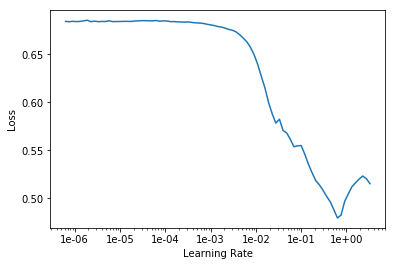

In [4]:
learn.recorder.plot()

这里5e-2看起来像一个很好的值，是曲线最小值的十分之一。 这将是1周期内最高的学习率，所以让我们尝试一下该值的持续训练。

In [5]:
learn.fit(2, 5e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.078264,0.039674,0.984789,00:56
1,0.041444,0.028893,0.989696,00:56


我们还可以看到当我们以较低的学习率训练时会发生什么

In [6]:
model = simple_cnn((3,16,16,2))
learn = Learner(data, model, metrics=[accuracy])
learn.fit(2, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.092246,0.074417,0.973013,00:56
1,0.088180,0.068065,0.973994,00:56


### 使用1周期策略进行培训
现在用1循环做同样的事情，我们使用fit_one_cycle。

In [7]:
model = simple_cnn((3,16,16,2))
learn = Learner(data, model, metrics=[accuracy])
learn.fit_one_cycle(2, 5e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.085647,0.049582,0.983317,00:56
1,0.028171,0.020881,0.992640,00:56


这是世界上最好的，我们可以看到我们如何在相同数量的时期获得更好的准确性和更低的损失。 通过不断学习率的培训，我们可以获得相同的惊人结果，我们会逐渐减少，但这需要更长的时间。

以下是新1循环策略使用的lrs（左）和动量（右）的时间表。

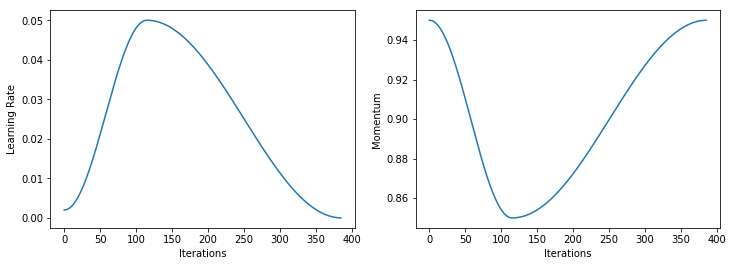

In [8]:
learn.recorder.plot_lr(show_moms=True)

### class OneCycleScheduler
`OneCycleScheduler(learn:Learner, lr_max:float, moms:Floats=(0.95, 0.85), div_factor:float=25.0, pct_start:float=0.3, final_div:float=None, tot_epochs:int=None, start_epoch:int=None) :: LearnerCallback`

如Leslie Smith的论文所述，管理1循环式培训。

创建一个回调，用于处理1循环学习策略后的超参数设置。 应该使用lr_find测试选择lr_max。 在阶段1中，学习率从lr_max / div_factor线性地变为lr_max，而动量从moms [0]线性地变为moms [1]。 在阶段2中，学习速率遵循从lr_max到0的余弦退火，因为动量从moms [1]到moms [0]，具有相同的退火。

<b>steps</b>

`steps(*steps_cfg:StartOptEnd)`

根据steps_cfg构建回调的调度程序。

回调方法
你不要自己调用 - 他们会被fastai的Callback系统自动调用，以启用该类的功能。

<b>on_train_begin</b>

`on_train_begin(n_epochs:int, epoch:int, **kwargs:Any)`

启动n_epochs训练的参数。

<b>on_batch_end</b>

`on_batch_end(train, **kwargs:Any)`

为下一批准备超参数。